In [2]:
import os
import pathlib
import random
import numpy as np
import matplotlib.pyplot as plt
 
import zipfile
import requests
import glob as glob
 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import image_dataset_from_directory
 
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

In [3]:
SEED_VALUE = 41
 
# Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [4]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 2
    IMG_HEIGHT:  int = 350
    IMG_WIDTH:   int = 400
    CHANNELS:    int = 3
    CUT_PLANE:   str = "coronal"

    DATA_ROOT_TARGET:  str = f'/home/jovyan/data/pre-processed-autopet-min-{CUT_PLANE}' 
    DATA_ROOT_TRAIN:  str = DATA_ROOT_TARGET + '/Train' 
    DATA_ROOT_VALID:  str = DATA_ROOT_TARGET + '/Valid'
    DATA_ROOT_TEST:   str = DATA_ROOT_TARGET + '/Test'
    # DATA_TEST_GT:     str = './dataset_traffic_signs_40_samples_per_class/Test.csv'
         
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:       int   = 32
    EPOCHS:           int   = 101
    LEARNING_RATE:    float = 0.01
    DROPOUT:          float = 0.6
    LAYERS_FINE_TUNE: int   = 8

In [5]:
train_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_TRAIN,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='int',        # Use integer encoding
                                             image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                            )
 
valid_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_VALID,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='int',        # Use integer encoding
                                             image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                            )

Found 722 files belonging to 2 classes.


2024-09-23 00:11:22.421532: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-23 00:11:22.444474: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-23 00:11:22.444644: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 80 files belonging to 2 classes.


In [6]:
!nvidia-smi

Mon Sep 23 00:11:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:01:00.0 Off |                  Off |
|  0%   49C    P2              63W / 450W |  22666MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
print(train_dataset.class_names)

['0', '1']


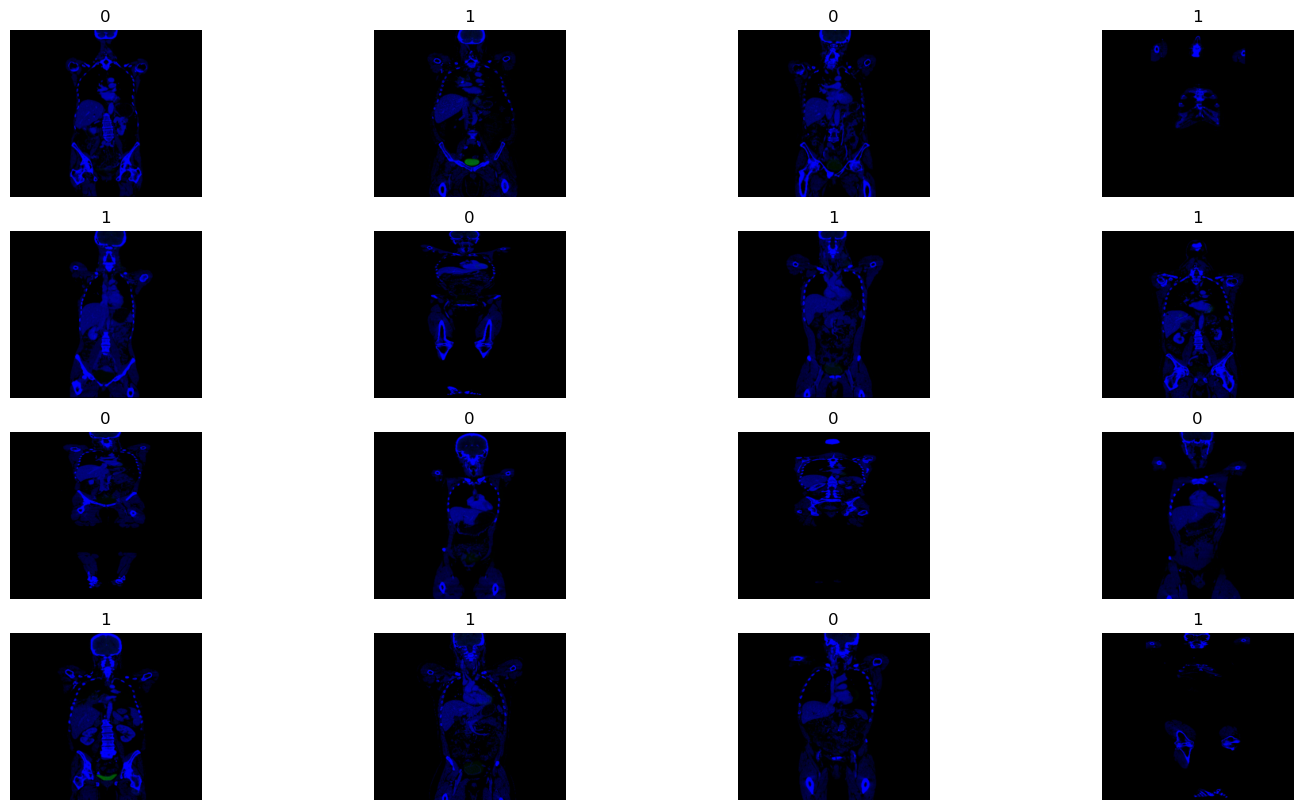

In [8]:
class_names = train_dataset.class_names
 
plt.figure(figsize=(18,10))
 
# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 4
 
# Here we use the take() method to retrieve just the first batch of data from the training portion of the dataset.
for image_batch, labels_batch in train_dataset.take(1): 
      
    # Plot each of the images in the batch and the associated ground truth labels.
    for i in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        truth_idx = labels_batch[i].numpy()
        plt.title(class_names[truth_idx])
        plt.axis("off")

In [9]:
# test_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_ids))

In [10]:
# def preprocess_image(image):
#     # Decode and resize image.
#     image = tf.image.decode_png(image, channels=3)
#     image = tf.image.resize(image, [DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT])
#     return image

In [11]:
# def load_and_preprocess_image(path):
#     # Read image into memory as a byte string.
#     image = tf.io.read_file(path)
#     return preprocess_image(image)

In [12]:
# def load_and_preprocess_from_path_label(path, label):
#     return load_and_preprocess_image(path), label

In [13]:
# # Apply the functions above to the test dataset.
# test_dataset = test_dataset.map(load_and_preprocess_from_path_label)
 
# # Set the batch size for the dataset.
# test_dataset = test_dataset.batch(TrainingConfig.BATCH_SIZE)

In [14]:
test_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_TEST,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='int',        # Use integer encoding
                                             image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                            )

Found 200 files belonging to 2 classes.


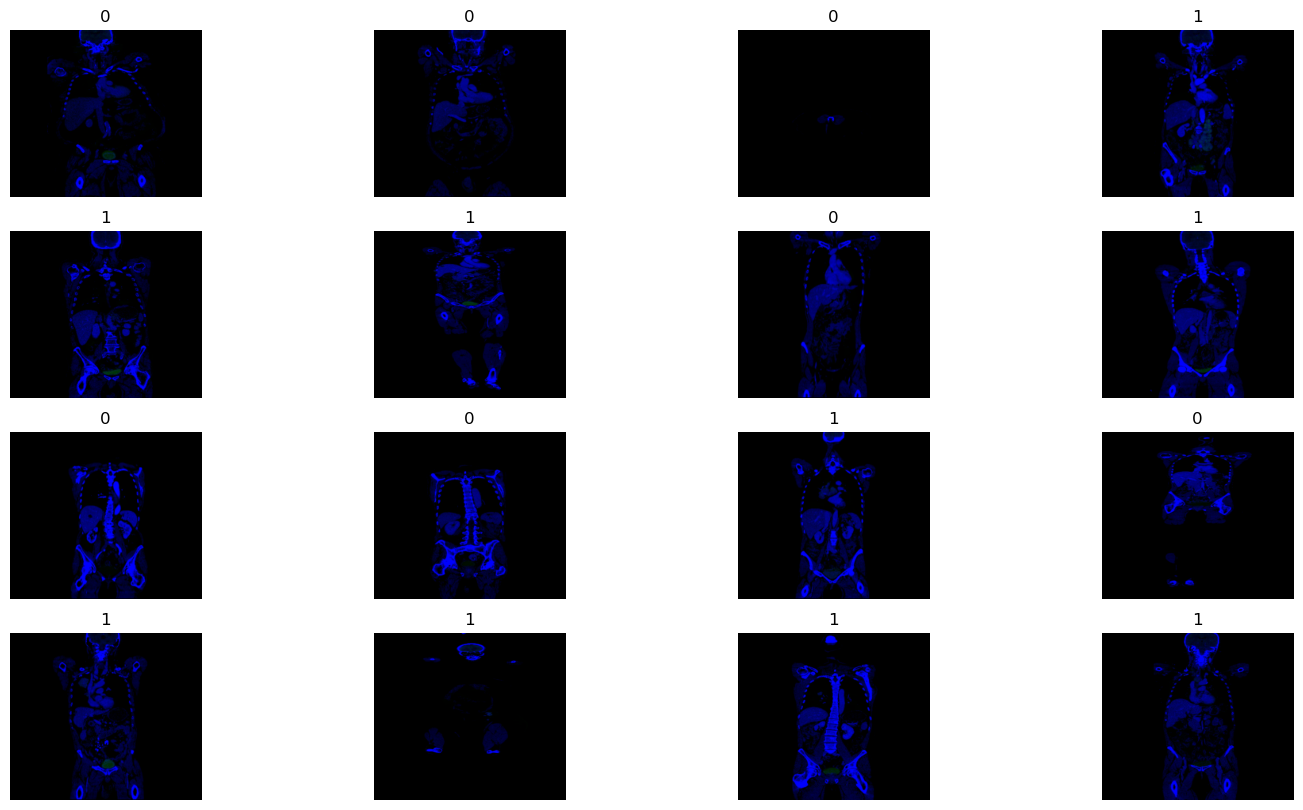

In [15]:
plt.figure(figsize=(18,10))
 
# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 4
 
# Here we use the take() method to retrieve just the first batch of data from the test dataset.
for image_batch, labels_batch in test_dataset.take(1):  
 
    # Plot each of the images in the batch and the associated ground truth labels.
    for i in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        truth_idx = labels_batch[i].numpy()
        plt.title(class_names[truth_idx])
        plt.axis("off")

In [16]:
# Specify the model input shape.
input_shape = (DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS)
 
print('Loading model with ImageNet weights...')
vgg16_conv_base = tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                                    include_top=False, # We will supply our own top.
                                                    weights='imagenet',
                                                   )
print(vgg16_conv_base.summary())

Loading model with ImageNet weights...
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 350, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 350, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 350, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 175, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 175, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 175, 200, 128)     147584    
                                                                 
 block2_pool (MaxPooli

In [17]:
# Set all layers in the convolutional base to Trainable (will FREEZE initial layers further below).
vgg16_conv_base.trainable = True
 
# Specify the number of layers to fine tune at the end of the convolutional base.
num_layers_fine_tune = TrainingConfig.LAYERS_FINE_TUNE
num_layers = len(vgg16_conv_base.layers)
 
# Freeze the initial layers in the convolutional base.
for model_layer in vgg16_conv_base.layers[:num_layers - num_layers_fine_tune]:
    print(f"FREEZING LAYER: {model_layer}")
    model_layer.trainable = False
 
print("\n")
print(f"Configured to fine tune the last", num_layers_fine_tune, "convolutional layers...")
print("\n")
     
print(vgg16_conv_base.summary())

FREEZING LAYER: <keras.src.engine.input_layer.InputLayer object at 0x7f523cb46c90>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f523c926550>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f523c9eedd0>
FREEZING LAYER: <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f523cb17010>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f523c9b8f50>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f523c970990>
FREEZING LAYER: <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f523c9bbbd0>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f523ca06510>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f523c95c8d0>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f523c9c73d0>
FREEZING LAYER: <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f523cc31710>


Configured to 

In [18]:
inputs = tf.keras.Input(shape=input_shape)
     
x = tf.keras.applications.vgg16.preprocess_input(inputs)
     
x = vgg16_conv_base(x)
 
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(TrainingConfig.DROPOUT)(x)
     
# The final `Dense` layer with the number of classes.
outputs = layers.Dense(DatasetConfig.NUM_CLASSES, activation='softmax')(x)
     
# The final model.
model_vgg16_finetune = keras.Model(inputs, outputs)
 
print(model_vgg16_finetune.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 350, 400, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 350, 400, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 350, 400, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 10, 12, 512)       14714688  
                                                                 
 flatten (Flatten)           (None, 61440)             0         
                                                                 
 dense (Dense)               (None, 128)               786444

In [19]:
# Use this for integer encoded labels.
model_vgg16_finetune.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'],
                   )

In [20]:
# Train the Model.
training_results = model_vgg16_finetune.fit(train_dataset,
                                            epochs=TrainingConfig.EPOCHS,
                                            validation_data=valid_dataset,
                                           )

Epoch 1/101


2024-09-23 00:11:27.049399: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-09-23 00:11:28.797024: I external/local_xla/xla/service/service.cc:168] XLA service 0x559b87b81250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-23 00:11:28.797049: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-09-23 00:11:28.801220: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1727050288.887577  492454 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/23 [==============================] - 10s 200ms/step - loss: 6546954.0000 - accuracy: 0.5125 - val_loss: 132.4241 - val_accuracy: 0.5000
Epoch 2/101
23/23 [==============================] - 2s 90ms/step - loss: 4879.9453 - accuracy: 0.5083 - val_loss: 0.7012 - val_accuracy: 0.5000
Epoch 3/101
23/23 [==============================] - 2s 90ms/step - loss: 0.7960 - accuracy: 0.5000 - val_loss: 0.6970 - val_accuracy: 0.5000
Epoch 4/101
23/23 [==============================] - 2s 91ms/step - loss: 0.9277 - accuracy: 0.5000 - val_loss: 0.6949 - val_accuracy: 0.5000
Epoch 5/101
23/23 [==============================] - 2s 90ms/step - loss: 0.6947 - accuracy: 0.5000 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 6/101
23/23 [==============================] - 2s 90ms/step - loss: 0.6943 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/101
23/23 [==============================] - 2s 91ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch

In [21]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
     
    fig, ax = plt.subplots(figsize=(15, 4))
 
    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
         
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
     
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show()
    plt.close()

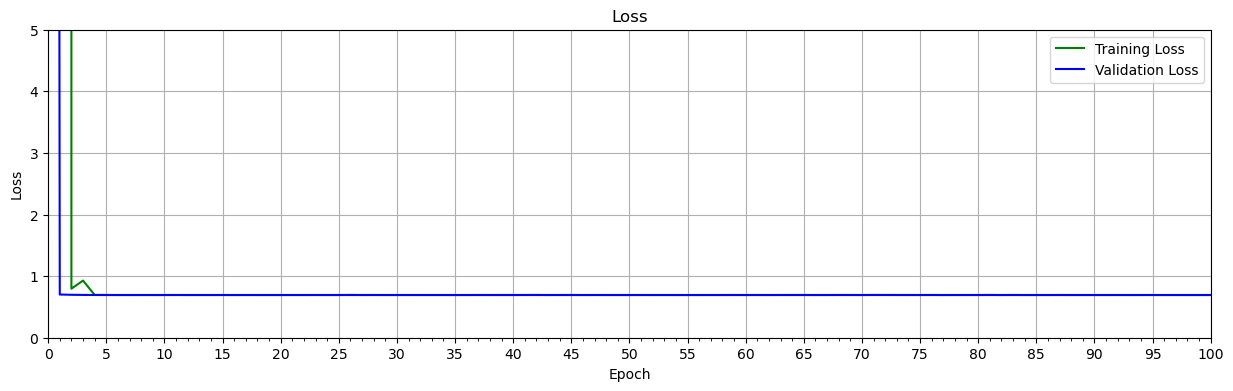

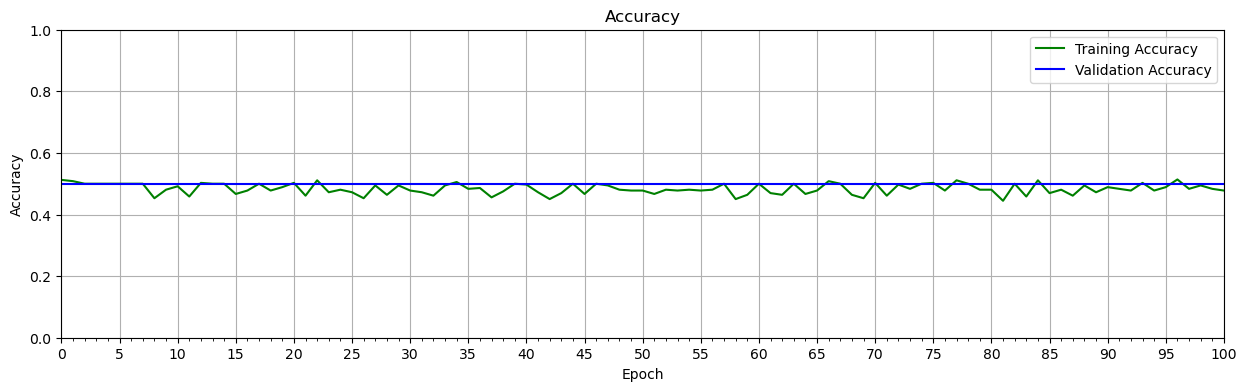

In [22]:
# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]
     
plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);
 
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

In [23]:
print(f"Model valid accuracy: {model_vgg16_finetune.evaluate(valid_dataset)[1]*100.:.3f}")

3/3 [==============================] - 0s 54ms/step - loss: 0.6932 - accuracy: 0.5000
Model valid accuracy: 50.000


In [24]:
print(f"Model test accuracy: {model_vgg16_finetune.evaluate(test_dataset)[1]*100.:.3f}")

7/7 [==============================] - 1s 114ms/step - loss: 0.6932 - accuracy: 0.5000
Model test accuracy: 50.000


In [25]:
def display_predictions(dataset, model, class_names):
     
    plt.figure(figsize=(20,20))
    num_rows = 8
    num_cols = 8
    jdx = 0
     
    # Evaluate all the batches.
    for image_batch, labels_batch in dataset.take(2):
         
        print(image_batch.shape)
         
        # Predictions for the current batch.
        predictions = model.predict(image_batch)
         
        # Loop over all the images in the current batch.
        for idx in range(len(labels_batch)):
             
            pred_idx = tf.argmax(predictions[idx]).numpy()
            truth_idx = labels_batch[idx].numpy()
             
            # Set the title color based on the prediction.
            if pred_idx == truth_idx:
                color='g'
            else:
                color='r'
                 
            jdx += 1
                 
            if jdx > num_rows*num_cols:
                # Break from the loops if the maximum number of images have been plotted
                break
                 
            ax = plt.subplot(num_rows, num_cols, jdx)
            title = str(class_names[truth_idx]) + " : " + str(class_names[pred_idx])
                 
            title_obj = plt.title(title)
            plt.setp(title_obj, color=color)
            plt.axis("off")
            plt.imshow(image_batch[idx].numpy().astype("uint8"));
    return

(32, 350, 400, 3)
1/1 [==============================] - 0s 138ms/step
(32, 350, 400, 3)
1/1 [==============================] - 0s 25ms/step


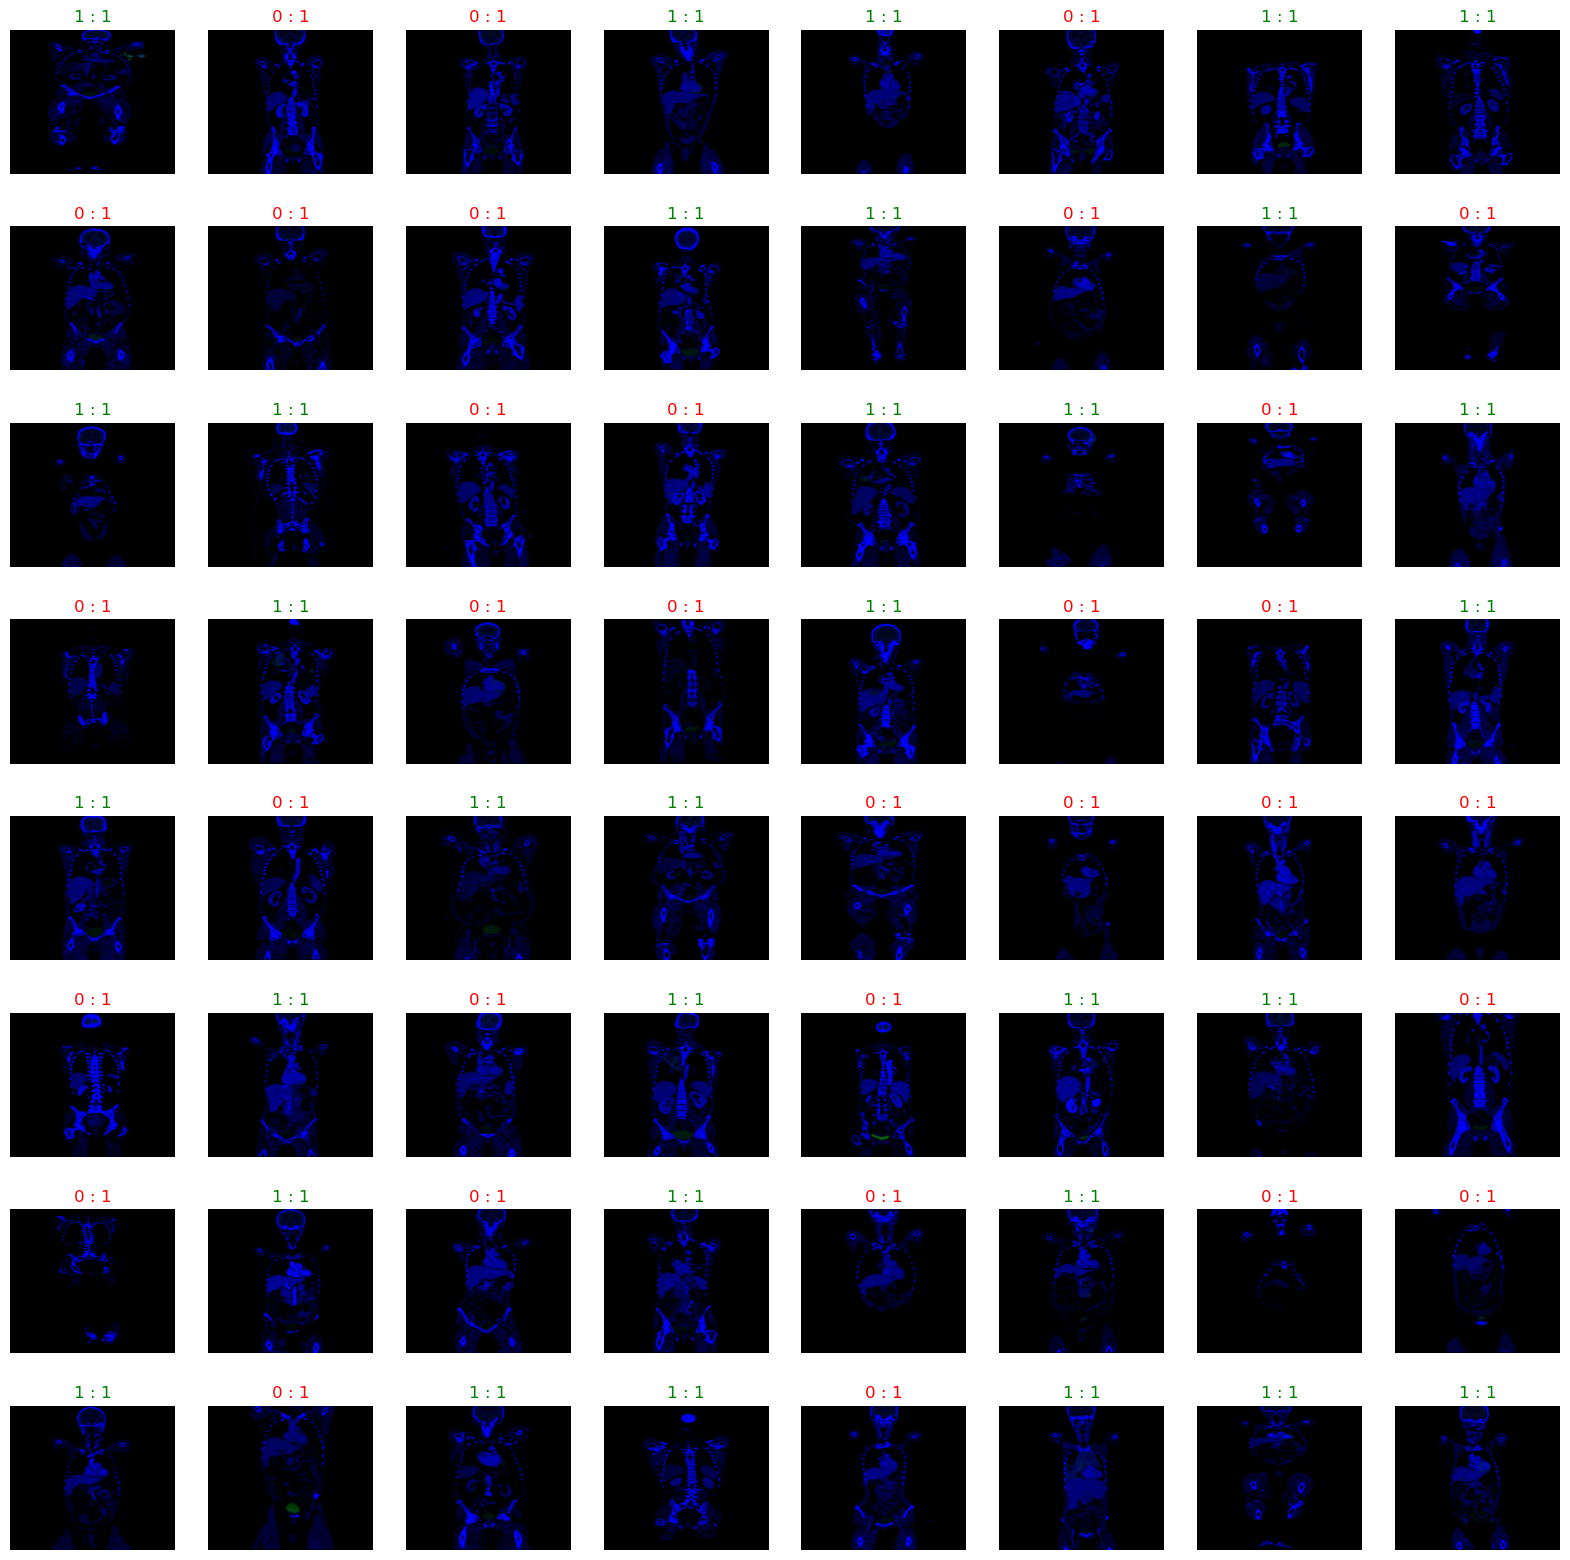

In [26]:
display_predictions(valid_dataset, model_vgg16_finetune, class_names)

(32, 350, 400, 3)
1/1 [==============================] - 0s 75ms/step
(32, 350, 400, 3)
1/1 [==============================] - 0s 26ms/step


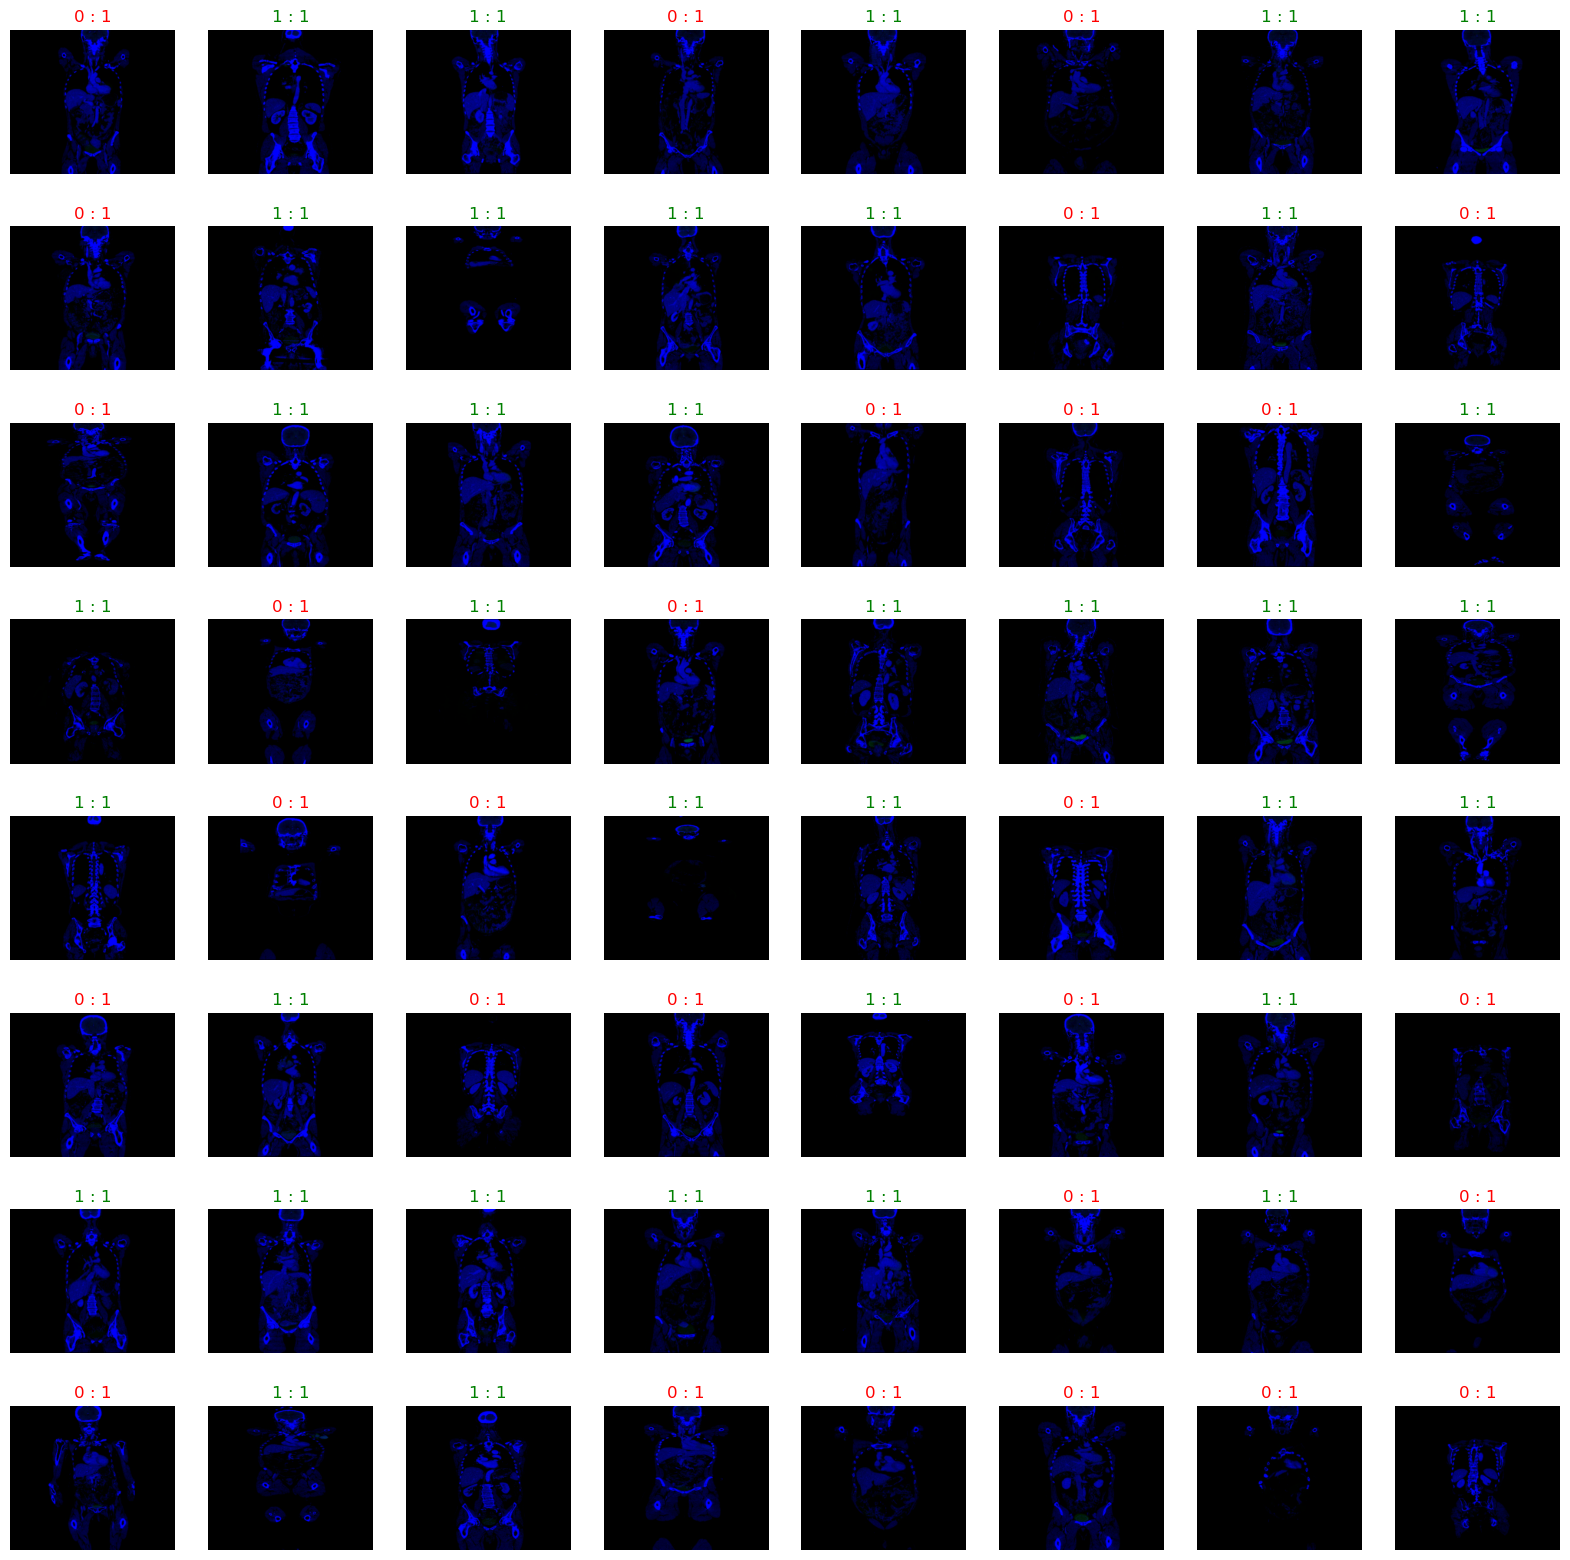

In [27]:
display_predictions(test_dataset, model_vgg16_finetune, class_names)